In [1]:
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
CONFIG = {
    'exchanges': {
        'binance': ccxt.binance({'enableRateLimit': True}),
        'bybit': ccxt.bybit({'enableRateLimit': True}),
        'okx': ccxt.okx({'enableRateLimit': True}),
    },
    'assets': ['BTC/USDT:USDT', 'ETH/USDT:USDT', 'SOL/USDT:USDT', 'AVAX/USDT:USDT'],
    'thresholds': {
        'min_funding_rate': 0.0005,  # 0.05% per 8h
        'min_annualized_return': 15,  # 15% annualized
        'min_liquidity': 10_000_000,  # $10M daily volume
        'max_volatility': 0.08,  # 8% daily volatility
        'min_correlation': 0.70,  # For pair trades
        'funding_differential': 0.001,  # 0.10% for cross-exchange arb
    }
}

print("✓ Configuration loaded")
print(f"Monitoring {len(CONFIG['assets'])} assets across {len(CONFIG['exchanges'])} exchanges")

✓ Configuration loaded
Monitoring 4 assets across 3 exchanges


In [3]:
def get_current_funding_rate(exchange, symbol):
    """Get current funding rate for a symbol"""
    try:
        funding = exchange.fetch_funding_rate(symbol)
        return {
            'exchange': exchange.id,
            'symbol': symbol,
            'funding_rate': funding.get('fundingRate', 0),
            'funding_rate_pct': funding.get('fundingRate', 0) * 100,
            'annualized_pct': funding.get('fundingRate', 0) * 3 * 365 * 100,
            'next_funding_time': funding.get('fundingTimestamp'),
            'mark_price': funding.get('markPrice'),
            'index_price': funding.get('indexPrice'),
            'timestamp': funding.get('timestamp')
        }
    except Exception as e:
        print(f"Error fetching funding for {symbol} on {exchange.id}: {str(e)}")
        return None


def get_funding_history(exchange, symbol, days=30):
    """Get historical funding rates"""
    try:
        since = exchange.milliseconds() - days * 24 * 60 * 60 * 1000
        history = exchange.fetch_funding_rate_history(symbol, since=since)
        
        df = pd.DataFrame(history)
        if not df.empty:
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
            df['funding_rate_pct'] = df['fundingRate'] * 100
            df['annualized_pct'] = df['fundingRate'] * 3 * 365 * 100
        return df
    except Exception as e:
        print(f"Error fetching history for {symbol} on {exchange.id}: {str(e)}")
        return pd.DataFrame()


def get_spot_price(exchange, symbol):
    """Get current spot price"""
    try:
        # Convert perp symbol to spot symbol (e.g., BTC/USDT:USDT -> BTC/USDT)
        spot_symbol = symbol.split(':')[0]
        ticker = exchange.fetch_ticker(spot_symbol)
        return ticker['last']
    except Exception as e:
        print(f"Error fetching spot price for {symbol}: {str(e)}")
        return None


def get_perp_price(exchange, symbol):
    """Get current perpetual price"""
    try:
        ticker = exchange.fetch_ticker(symbol)
        return ticker['last']
    except Exception as e:
        print(f"Error fetching perp price for {symbol}: {str(e)}")
        return None


def get_orderbook_depth(exchange, symbol, price_range_pct=0.001):
    """Analyze orderbook depth within price range"""
    try:
        orderbook = exchange.fetch_order_book(symbol, limit=100)
        current_price = (orderbook['bids'][0][0] + orderbook['asks'][0][0]) / 2
        
        # Calculate depth within price range
        price_threshold_bid = current_price * (1 - price_range_pct)
        price_threshold_ask = current_price * (1 + price_range_pct)
        
        bid_depth = sum(price * size for price, size in orderbook['bids'] 
                       if price >= price_threshold_bid)
        ask_depth = sum(price * size for price, size in orderbook['asks'] 
                       if price <= price_threshold_ask)
        
        return {
            'bid_depth': bid_depth,
            'ask_depth': ask_depth,
            'total_depth': bid_depth + ask_depth,
            'spread_pct': (orderbook['asks'][0][0] - orderbook['bids'][0][0]) / current_price * 100
        }
    except Exception as e:
        print(f"Error fetching orderbook for {symbol}: {str(e)}")
        return None


def get_volume_24h(exchange, symbol):
    """Get 24h trading volume"""
    try:
        ticker = exchange.fetch_ticker(symbol)
        return ticker.get('quoteVolume', 0)  # Volume in USDT
    except Exception as e:
        print(f"Error fetching volume for {symbol}: {str(e)}")
        return 0


def calculate_volatility(exchange, symbol, days=30):
    """Calculate historical volatility"""
    try:
        since = exchange.milliseconds() - days * 24 * 60 * 60 * 1000
        ohlcv = exchange.fetch_ohlcv(symbol, '1d', since=since)
        
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['returns'] = df['close'].pct_change()
        volatility = df['returns'].std()
        
        return volatility
    except Exception as e:
        print(f"Error calculating volatility for {symbol}: {str(e)}")
        return None


In [4]:
def collect_all_data():
    """Collect comprehensive data for all assets across all exchanges"""
    
    print("Collecting data... This may take a few minutes.")
    all_data = []
    
    for exchange_name, exchange in CONFIG['exchanges'].items():
        print(f"\n📊 Collecting from {exchange_name.upper()}...")
        
        for symbol in CONFIG['assets']:
            print(f"  • {symbol}...", end=' ')
            
            try:
                # Get current funding rate
                funding_data = get_current_funding_rate(exchange, symbol)
                if not funding_data:
                    print("❌ Failed")
                    continue
                
                # Get historical funding
                funding_history = get_funding_history(exchange, symbol, days=7)
                
                # Get prices
                spot_price = get_spot_price(exchange, symbol)
                perp_price = get_perp_price(exchange, symbol)
                
                # Calculate basis
                basis = None
                basis_pct = None
                if spot_price and perp_price:
                    basis = perp_price - spot_price
                    basis_pct = (basis / spot_price) * 100
                
                # Get liquidity metrics
                volume_24h = get_volume_24h(exchange, symbol)
                orderbook = get_orderbook_depth(exchange, symbol)
                
                # Calculate volatility
                volatility = calculate_volatility(exchange, symbol, days=30)
                
                # Calculate average funding rates
                avg_funding_7d = funding_history['fundingRate'].mean() if not funding_history.empty else 0
                avg_funding_24h = funding_history.tail(3)['fundingRate'].mean() if len(funding_history) >= 3 else 0
                
                # Compile data
                data = {
                    **funding_data,
                    'spot_price': spot_price,
                    'perp_price': perp_price,
                    'basis': basis,
                    'basis_pct': basis_pct,
                    'volume_24h': volume_24h,
                    'volatility': volatility,
                    'avg_funding_7d': avg_funding_7d,
                    'avg_funding_24h': avg_funding_24h,
                    'avg_annualized_7d': avg_funding_7d * 3 * 365 * 100,
                    'spread_pct': orderbook['spread_pct'] if orderbook else None,
                    'orderbook_depth': orderbook['total_depth'] if orderbook else None,
                }
                
                all_data.append(data)
                print("✓")
                
                # Rate limiting
                time.sleep(exchange.rateLimit / 1000)
                
            except Exception as e:
                print(f"❌ Error: {str(e)}")
    
    df = pd.DataFrame(all_data)
    print(f"\n✓ Collected data for {len(df)} instruments")
    return df


In [5]:
data = collect_all_data()


📊 Collecting from BINANCE...
  • BTC/USDT:USDT... ✓
  • ETH/USDT:USDT... ✓
  • SOL/USDT:USDT... ✓
  • AVAX/USDT:USDT... ✓

📊 Collecting from BYBIT...
  • BTC/USDT:USDT... ✓
  • ETH/USDT:USDT... ✓
  • SOL/USDT:USDT... ✓
  • AVAX/USDT:USDT... ✓

📊 Collecting from OKX...
  • BTC/USDT:USDT... Error fetching orderbook for BTC/USDT:USDT: too many values to unpack (expected 2)
✓
  • ETH/USDT:USDT... Error fetching orderbook for ETH/USDT:USDT: too many values to unpack (expected 2)
✓
  • SOL/USDT:USDT... Error fetching orderbook for SOL/USDT:USDT: too many values to unpack (expected 2)
✓
  • AVAX/USDT:USDT... Error fetching orderbook for AVAX/USDT:USDT: too many values to unpack (expected 2)
✓

✓ Collected data for 12 instruments


In [8]:
def screen_cash_and_carry(df, thresholds):
    """Screen for cash-and-carry arbitrage opportunities"""
    
    opportunities = df[
        (df['funding_rate_pct'] > thresholds['min_funding_rate'] * 100) &
        (df['avg_annualized_7d'] > thresholds['min_annualized_return']) &
        (df['basis_pct'] > 0) &
        (df['volume_24h'] > thresholds['min_liquidity']) &
        (df['volatility'] < thresholds['max_volatility'])
    ].copy()
    
    # Calculate expected returns
    opportunities['expected_monthly_return'] = opportunities['annualized_pct'] / 12
    opportunities['risk_score'] = (
        opportunities['volatility'] * 10 + 
        (1 / opportunities['volume_24h'] * 1e8)
    )
    
    # Calculate Sharpe-like score
    opportunities['return_risk_ratio'] = (
        opportunities['annualized_pct'] / (opportunities['volatility'] * 100)
    )
    
    return opportunities.sort_values('annualized_pct', ascending=False)


def screen_cross_exchange(df, thresholds):
    """Screen for cross-exchange funding arbitrage"""
    
    cross_exchange_opps = []
    
    # Group by symbol
    for symbol in df['symbol'].unique():
        symbol_data = df[df['symbol'] == symbol].copy()
        
        # Compare all exchange pairs
        exchanges = symbol_data['exchange'].unique()
        for i, ex1 in enumerate(exchanges):
            for ex2 in exchanges[i+1:]:
                data1 = symbol_data[symbol_data['exchange'] == ex1].iloc[0]
                data2 = symbol_data[symbol_data['exchange'] == ex2].iloc[0]
                
                funding_diff = abs(data1['funding_rate'] - data2['funding_rate'])
                
                if funding_diff > thresholds['funding_differential']:
                    # Determine which side to take on each exchange
                    if data1['funding_rate'] > data2['funding_rate']:
                        long_exchange = ex2
                        short_exchange = ex1
                        net_funding = data1['funding_rate'] - data2['funding_rate']
                    else:
                        long_exchange = ex1
                        short_exchange = ex2
                        net_funding = data2['funding_rate'] - data1['funding_rate']
                    
                    cross_exchange_opps.append({
                        'symbol': symbol,
                        'long_exchange': long_exchange,
                        'short_exchange': short_exchange,
                        'funding_differential': funding_diff,
                        'funding_diff_pct': funding_diff * 100,
                        'annualized_pct': net_funding * 3 * 365 * 100,
                        'monthly_return_pct': net_funding * 3 * 365 * 100 / 12,
                    })
    
    # Return empty DataFrame with correct columns if no opportunities found
    if not cross_exchange_opps:
        return pd.DataFrame(columns=['symbol', 'long_exchange', 'short_exchange', 
                                    'funding_differential', 'funding_diff_pct', 
                                    'annualized_pct', 'monthly_return_pct'])
    
    return pd.DataFrame(cross_exchange_opps).sort_values('annualized_pct', ascending=False)


def calculate_correlation_matrix(days=30):
    """Calculate correlation matrix for multi-asset strategies"""
    
    print("Calculating correlation matrix...")
    price_data = {}
    
    exchange = CONFIG['exchanges']['binance']
    
    for symbol in CONFIG['assets']:
        try:
            since = exchange.milliseconds() - days * 24 * 60 * 60 * 1000
            ohlcv = exchange.fetch_ohlcv(symbol, '1h', since=since)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('datetime', inplace=True)
            price_data[symbol] = df['close']
            time.sleep(exchange.rateLimit / 1000)
        except Exception as e:
            print(f"Error fetching data for {symbol}: {str(e)}")
    
    # Combine into single dataframe
    prices_df = pd.DataFrame(price_data)
    
    # Calculate returns
    returns_df = prices_df.pct_change().dropna()
    
    # Calculate correlation
    correlation_matrix = returns_df.corr()
    
    return correlation_matrix, returns_df


def screen_pair_trades(df, correlation_matrix, thresholds):
    """Screen for pair trading opportunities based on correlation and funding differentials"""
    
    pair_opps = []
    
    # Get unique symbols
    symbols = df['symbol'].unique()
    
    # Compare all pairs
    for i, sym1 in enumerate(symbols):
        for sym2 in symbols[i+1:]:
            # Check correlation
            if sym1 not in correlation_matrix.columns or sym2 not in correlation_matrix.columns:
                continue
            
            correlation = correlation_matrix.loc[sym1, sym2]
            
            if correlation > thresholds['min_correlation']:
                # Get funding rates (use first exchange as reference)
                data1 = df[df['symbol'] == sym1].iloc[0]
                data2 = df[df['symbol'] == sym2].iloc[0]
                
                funding_diff = abs(data1['funding_rate'] - data2['funding_rate'])
                
                if funding_diff > thresholds['funding_differential']:
                    # Determine positions
                    if data1['funding_rate'] > data2['funding_rate']:
                        long_symbol = sym2
                        short_symbol = sym1
                        net_funding = data1['funding_rate'] - data2['funding_rate']
                    else:
                        long_symbol = sym1
                        short_symbol = sym2
                        net_funding = data2['funding_rate'] - data1['funding_rate']
                    
                    pair_opps.append({
                        'pair': f"{long_symbol} / {short_symbol}",
                        'long_asset': long_symbol,
                        'short_asset': short_symbol,
                        'correlation': correlation,
                        'funding_differential': funding_diff,
                        'funding_diff_pct': funding_diff * 100,
                        'annualized_return': net_funding * 3 * 365 * 100,
                        'monthly_return': net_funding * 3 * 365 * 100 / 12,
                    })
    
    # Return empty DataFrame with correct columns if no opportunities found
    if not pair_opps:
        return pd.DataFrame(columns=['pair', 'long_asset', 'short_asset', 'correlation',
                                    'funding_differential', 'funding_diff_pct', 
                                    'annualized_return', 'monthly_return'])
    
    return pd.DataFrame(pair_opps).sort_values('annualized_return', ascending=False)

In [9]:
print("\n" + "="*80)
print("RUNNING ANALYSIS")
print("="*80)

# Screen for opportunities
print("\n1️⃣ Screening for Cash-and-Carry opportunities...")
cash_carry_opps = screen_cash_and_carry(data, CONFIG['thresholds'])

print("\n2️⃣ Screening for Cross-Exchange arbitrage...")
cross_exchange_opps = screen_cross_exchange(data, CONFIG['thresholds'])

print("\n3️⃣ Calculating asset correlations...")
correlation_matrix, returns_df = calculate_correlation_matrix(days=30)

print("\n4️⃣ Screening for Pair Trade opportunities...")
pair_trade_opps = screen_pair_trades(data, correlation_matrix, CONFIG['thresholds'])


RUNNING ANALYSIS

1️⃣ Screening for Cash-and-Carry opportunities...

2️⃣ Screening for Cross-Exchange arbitrage...

3️⃣ Calculating asset correlations...
Calculating correlation matrix...

4️⃣ Screening for Pair Trade opportunities...


In [10]:
def visualize_opportunities():
    """Create comprehensive visualization dashboard"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Funding Rates Heatmap
    plt.subplot(2, 3, 1)
    pivot_funding = data.pivot_table(
        values='annualized_pct', 
        index='symbol', 
        columns='exchange'
    )
    sns.heatmap(pivot_funding, annot=True, fmt='.1f', cmap='RdYlGn', center=0)
    plt.title('Funding Rates Heatmap (Annualized %)', fontsize=14, fontweight='bold')
    plt.ylabel('')
    
    # 2. Basis Distribution
    plt.subplot(2, 3, 2)
    data_with_basis = data.dropna(subset=['basis_pct'])
    colors = ['green' if x > 0 else 'red' for x in data_with_basis['basis_pct']]
    plt.barh(
        data_with_basis['symbol'] + ' (' + data_with_basis['exchange'] + ')', 
        data_with_basis['basis_pct'],
        color=colors,
        alpha=0.7
    )
    plt.xlabel('Basis (%)')
    plt.title('Perp vs Spot Basis', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    
    # 3. Volume vs Funding Rate
    plt.subplot(2, 3, 3)
    plt.scatter(
        data['volume_24h'] / 1e6, 
        data['annualized_pct'],
        s=100,
        alpha=0.6,
        c=data['volatility'],
        cmap='coolwarm'
    )
    plt.xlabel('24h Volume ($M)')
    plt.ylabel('Annualized Funding Rate (%)')
    plt.title('Volume vs Funding Rate', fontsize=14, fontweight='bold')
    plt.colorbar(label='Volatility')
    
    # Add labels for each point
    for idx, row in data.iterrows():
        plt.annotate(
            row['symbol'].split('/')[0], 
            (row['volume_24h'] / 1e6, row['annualized_pct']),
            fontsize=8,
            alpha=0.7
        )
    
    # 4. Correlation Matrix
    plt.subplot(2, 3, 4)
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Asset Correlation Matrix (30d)', fontsize=14, fontweight='bold')
    
    # 5. Top Opportunities
    plt.subplot(2, 3, 5)
    if not cash_carry_opps.empty:
        top_opps = cash_carry_opps.head(10)
        plt.barh(
            top_opps['symbol'] + ' (' + top_opps['exchange'] + ')',
            top_opps['annualized_pct'],
            color='steelblue',
            alpha=0.7
        )
        plt.xlabel('Annualized Return (%)')
        plt.title('Top 10 Cash-and-Carry Opportunities', fontsize=14, fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'No opportunities found', ha='center', va='center', fontsize=12)
        plt.axis('off')
    
    # 6. Risk-Return Scatter
    plt.subplot(2, 3, 6)
    if not cash_carry_opps.empty:
        plt.scatter(
            cash_carry_opps['volatility'] * 100,
            cash_carry_opps['annualized_pct'],
            s=cash_carry_opps['volume_24h'] / 1e5,
            alpha=0.6,
            c=cash_carry_opps['return_risk_ratio'],
            cmap='viridis'
        )
        plt.xlabel('Volatility (%)')
        plt.ylabel('Expected Return (%)')
        plt.title('Risk-Return Profile', fontsize=14, fontweight='bold')
        plt.colorbar(label='Return/Risk Ratio')
        
        # Add labels
        for idx, row in cash_carry_opps.iterrows():
            plt.annotate(
                row['symbol'].split('/')[0],
                (row['volatility'] * 100, row['annualized_pct']),
                fontsize=8,
                alpha=0.7
            )
    
    plt.tight_layout()
    plt.show()

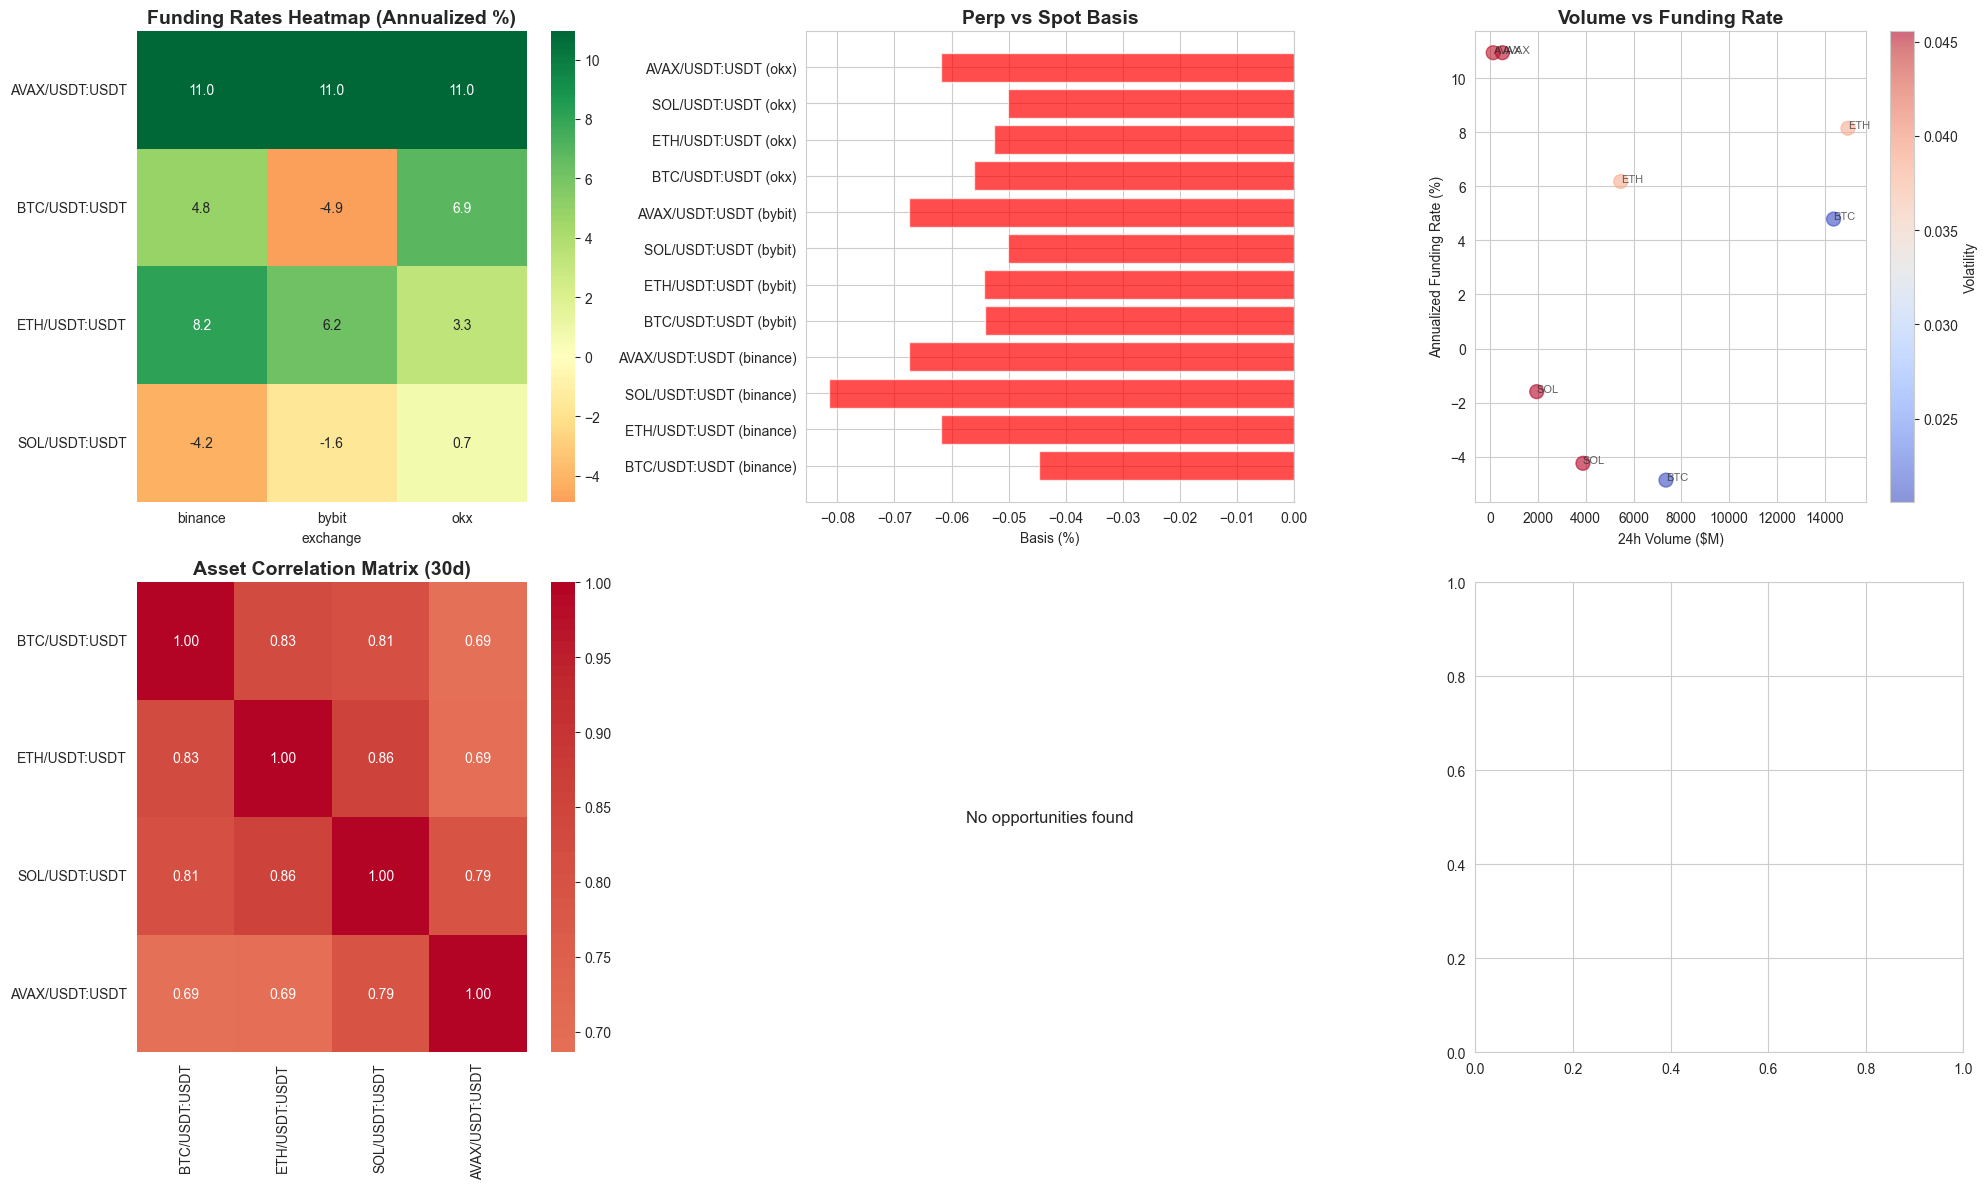

In [11]:
visualize_opportunities()

In [12]:
def generate_opportunity_report():
    """Generate comprehensive text report of opportunities"""
    
    print("\n" + "="*80)
    print("📊 OPPORTUNITY DASHBOARD")
    print("="*80)
    
    # Cash and Carry Opportunities
    print("\n🎯 CASH-AND-CARRY OPPORTUNITIES")
    print("-" * 80)
    if not cash_carry_opps.empty:
        print(f"\nFound {len(cash_carry_opps)} opportunities:\n")
        
        for idx, row in cash_carry_opps.head(5).iterrows():
            print(f"{'='*80}")
            print(f"Asset: {row['symbol']} on {row['exchange'].upper()}")
            print(f"Current Funding Rate: {row['funding_rate_pct']:.4f}% per 8h")
            print(f"Annualized Return: {row['annualized_pct']:.2f}%")
            print(f"Monthly Return: {row['expected_monthly_return']:.2f}%")
            print(f"7-Day Avg Return: {row['avg_annualized_7d']:.2f}%")
            print(f"Basis: {row['basis_pct']:.2f}%")
            print(f"24h Volume: ${row['volume_24h']/1e6:.2f}M")
            print(f"Volatility: {row['volatility']*100:.2f}%")
            print(f"Return/Risk Ratio: {row['return_risk_ratio']:.2f}")
            print(f"\n💡 Strategy: Buy spot + Short perp")
            print(f"   Expected earnings: ${10000 * row['annualized_pct']/100:.2f} per $10k position annually")
            print()
    else:
        print("No opportunities meeting criteria found.")
    
    # Cross-Exchange Opportunities
    print("\n🔄 CROSS-EXCHANGE ARBITRAGE")
    print("-" * 80)
    if not cross_exchange_opps.empty:
        print(f"\nFound {len(cross_exchange_opps)} opportunities:\n")
        
        for idx, row in cross_exchange_opps.head(5).iterrows():
            print(f"{'='*80}")
            print(f"Asset: {row['symbol']}")
            print(f"Long on: {row['long_exchange'].upper()}")
            print(f"Short on: {row['short_exchange'].upper()}")
            print(f"Funding Differential: {row['funding_diff_pct']:.4f}% per 8h")
            print(f"Annualized Return: {row['annualized_pct']:.2f}%")
            print(f"Monthly Return: {row['monthly_return_pct']:.2f}%")
            print(f"\n💡 Strategy: Long perp on {row['long_exchange']} + Short perp on {row['short_exchange']}")
            print(f"   Expected earnings: ${10000 * row['annualized_pct']/100:.2f} per $10k position annually")
            print()
    else:
        print("No opportunities meeting criteria found.")
    
    # Pair Trade Opportunities
    print("\n🔗 PAIR TRADE OPPORTUNITIES")
    print("-" * 80)
    if not pair_trade_opps.empty:
        print(f"\nFound {len(pair_trade_opps)} opportunities:\n")
        
        for idx, row in pair_trade_opps.head(5).iterrows():
            print(f"{'='*80}")
            print(f"Pair: {row['pair']}")
            print(f"Correlation: {row['correlation']:.3f}")
            print(f"Funding Differential: {row['funding_diff_pct']:.4f}% per 8h")
            print(f"Annualized Return: {row['annualized_return']:.2f}%")
            print(f"Monthly Return: {row['monthly_return']:.2f}%")
            print(f"\n💡 Strategy: Long {row['long_asset']} perp + Short {row['short_asset']} perp")
            print(f"   Expected earnings: ${10000 * row['annualized_return']/100:.2f} per $10k position annually")
            print()
    else:
        print("No opportunities meeting criteria found.")
    
    # Summary Statistics
    print("\n📈 SUMMARY STATISTICS")
    print("-" * 80)
    print(f"Total instruments analyzed: {len(data)}")
    print(f"Cash-and-carry opportunities: {len(cash_carry_opps)}")
    print(f"Cross-exchange opportunities: {len(cross_exchange_opps)}")
    print(f"Pair trade opportunities: {len(pair_trade_opps)}")
    print(f"\nAverage funding rate: {data['funding_rate_pct'].mean():.4f}%")
    print(f"Highest funding rate: {data['funding_rate_pct'].max():.4f}% ({data.loc[data['funding_rate_pct'].idxmax(), 'symbol']})")
    print(f"Average annualized return: {data['annualized_pct'].mean():.2f}%")

In [13]:
generate_opportunity_report()


📊 OPPORTUNITY DASHBOARD

🎯 CASH-AND-CARRY OPPORTUNITIES
--------------------------------------------------------------------------------
No opportunities meeting criteria found.

🔄 CROSS-EXCHANGE ARBITRAGE
--------------------------------------------------------------------------------
No opportunities meeting criteria found.

🔗 PAIR TRADE OPPORTUNITIES
--------------------------------------------------------------------------------
No opportunities meeting criteria found.

📈 SUMMARY STATISTICS
--------------------------------------------------------------------------------
Total instruments analyzed: 12
Cash-and-carry opportunities: 0
Cross-exchange opportunities: 0
Pair trade opportunities: 0

Average funding rate: 0.0040%
Highest funding rate: 0.0100% (AVAX/USDT:USDT)
Average annualized return: 4.34%
